# **Importing Important Libraries**

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras 
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import pathlib 
import os 
import PIL
from PIL import Image

# **Loading and Preprocessing Data**

In [2]:
data_dir = pathlib.Path("Custom-Dataset")
# print(len(list(data_dir.glob("*/*"))))


In [ ]:
trash = list(data_dir.glob('Can/*'))
PIL.Image.open(str(trash[0]))

In [3]:
batch_size = 32
image_height = 224
image_width = 224

In [4]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.1,
  subset="training",
  seed=123,
  image_size=(image_height, image_width),
  batch_size=batch_size)

Found 21000 files belonging to 3 classes.
Using 18900 files for training.


In [5]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.1,
  subset="validation",
  seed=123,
  image_size=(image_height, image_width),
  batch_size=batch_size)

Found 21000 files belonging to 3 classes.
Using 2100 files for validation.


In [ ]:
val_batches = tf.data.experimental.cardinality(val_ds)
test_ds = val_ds.take(val_batches // 2)
val_ds = val_ds.skip(val_batches // 2)

In [ ]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(val_ds))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_ds))

In [ ]:
#Classes as inferred
class_names = train_ds.class_names
print(class_names)

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

# **Configure Dataset Performance**

In [6]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)
# test_ds= test_ds.prefetch(buffer_size=AUTOTUNE)

# **Data Augmentation**

In [ ]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

## Load The Pre-trained Model - **RESNET50**

In [ ]:
#importing ResNet50
from tensorflow.keras.applications import ResNet50
# from tensorflow.keras.applications.vgg16 import preprocess_input

In [ ]:
# Load ResNet50 as the base model
def build_model():
  base_model = ResNet50(include_top=False, weights='imagenet', input_shape=(224,224,3))

  # Freeze the base model's layers
  for layer in base_model.layers:
      layer.trainable = False
      
  # Add your own layers on top of the base model

  inputs = tf.keras.Input(shape=(image_height, image_width, 3))

  x = data_augmentation(inputs)

  x = base_model(x, training=False)

  x = layers.GlobalAveragePooling2D()(x)
  x = layers.Dense(256, activation='relu')(x)
  x = layers.Dense(256, activation='relu')(x)
  x = layers.Dropout(0.5)(x)
  x = layers.Flatten()(x)
  num_classes = 3
  predictions = layers.Dense(num_classes, activation='softmax')(x)

  # Create the final model
  model = tf.keras.Model(inputs=inputs, outputs=predictions)

  model.compile(optimizer=tf.keras.optimizers.Adam(),loss=tf.keras.losses.SparseCategoricalCrossentropy(),metrics=['accuracy'])

  return model

In [ ]:
# Load ResNet50 as the base model
def build_model():
  base_model = ResNet50(include_top=False, weights='imagenet', input_shape=(224,224,3))

  # Freeze the base model's layers
  for layer in base_model.layers:
      layer.trainable = False
      
  # Add your own layers on top of the base model

  inputs = tf.keras.Input(shape=(image_height, image_width, 3))

  x = data_augmentation(inputs)

  x = base_model(x, training=False)

  x = layers.GlobalAveragePooling2D()(x)
  x = layers.Dense(256, activation='relu')(x)
  x = layers.Dense(256, activation='relu')(x)
  x = layers.Dropout(0.5)(x)
  x = layers.Flatten()(x)
  num_classes = 3
  predictions = layers.Dense(num_classes, activation='softmax')(x)

  # Create the final model
  model = tf.keras.Model(inputs=inputs, outputs=predictions)

  model.compile(optimizer=tf.keras.optimizers.Adam(),loss=tf.keras.losses.SparseCategoricalCrossentropy(),metrics=['accuracy'])

  return model

In [ ]:
model.summary()

In [ ]:
model.summary()

In [90]:
layer_to_remove

In [8]:
# Get a reference to the layer you want to remove
layer_to_remove = model.get_layer('flatten')

# Create a list to hold the remaining layers
remaining_layers = []

# Iterate over the layers and exclude the layer to remove
for layer in model.layers:
    if layer == layer_to_remove:
        # Skip the layer you want to remove
        continue
    # Add the remaining layers to the list
    remaining_layers.append(layer)

# Define the new model with the remaining layers
inputs = model.input
outputs = remaining_layers[0](inputs)
for layer in remaining_layers[1:]:
    outputs = layer(outputs)
new_model = tf.keras.models.Model(inputs, outputs)


Note that input tensors are instantiated via `tensor = tf.keras.Input(shape)`.
The tensor that caused the issue was: KerasTensor(type_spec=TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_2'), name='input_2', description="created by layer 'input_2'")


In [9]:
new_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           multiple             0           ['input_2[0][0]']                
                                                                                                  
 sequential (Sequential)        (None, 224, 224, 3)  0           ['input_2[1][0]']                
                                                                                                  
 resnet50 (Functional)          (None, 7, 7, 2048)   23587712    ['sequential[1][0]']             
                                                                                                  
 global_average_pooling2d (Glob  (None, 2048)        0           ['resnet50[1][0]']               
 alAveragePooling2D)                                                                          

In [20]:
from tensorflow.keras.callbacks import ModelCheckpoint

In [38]:
model = tf.keras.models.load_model("Models/ResNet50-STBv1.0_10")


In [39]:
model.layers[-1].units = 3

In [40]:
model.layers[-1].get_config()

{'name': 'dense_2',
 'trainable': True,
 'dtype': 'float32',
 'units': 3,
 'activation': 'softmax',
 'use_bias': True,
 'kernel_initializer': {'class_name': 'GlorotUniform',
  'config': {'seed': None}},
 'bias_initializer': {'class_name': 'Zeros', 'config': {}},
 'kernel_regularizer': None,
 'bias_regularizer': None,
 'activity_regularizer': None,
 'kernel_constraint': None,
 'bias_constraint': None}

In [ ]:
model = build_model()

In [41]:
for layer in model.layers:
  print(layer.trainable)

True
True
True
True
True
True
True
True


In [42]:
for layer in new_model.layers[2].layers:
  layer.trainable = False

In [49]:
model.layers[2].layers[39].get_config()

{'name': 'conv3_block1_1_conv',
 'trainable': False,
 'dtype': 'float32',
 'filters': 128,
 'kernel_size': (1, 1),
 'strides': (2, 2),
 'padding': 'valid',
 'data_format': 'channels_last',
 'dilation_rate': (1, 1),
 'groups': 1,
 'activation': 'linear',
 'use_bias': True,
 'kernel_initializer': {'class_name': 'GlorotUniform',
  'config': {'seed': None}},
 'bias_initializer': {'class_name': 'Zeros', 'config': {}},
 'kernel_regularizer': None,
 'bias_regularizer': None,
 'activity_regularizer': None,
 'kernel_constraint': None,
 'bias_constraint': None}

In [50]:
for layer in new_model.layers[2].layers[7:39]:
  layer.trainable = True

In [51]:
# METRICS=[tf.keras.metrics.CategoricalAccuracy(name='accuracy'),
#             tf.keras.metrics.Precision(name='precision'),
#             tf.keras.metrics.Recall(name='recall'),]
model.compile(optimizer=tf.keras.optimizers.SGD(lr=1e-4, momentum=0.9),loss=tf.keras.losses.CategoricalCrossentropy(),metrics=[tf.keras.metrics.Precision()])

In [66]:
# Create a function to convert labels to one-hot encoding
num_classes = 4
def to_one_hot(x, y):
    num_classes = 3
    y_one_hot = tf.one_hot(y, num_classes)
    return x, y_one_hot

In [15]:
train_ds = train_ds.map(to_one_hot)

In [16]:
val_ds = val_ds.map(to_one_hot)

In [67]:
test_ds = test_ds.map(to_one_hot)

In [52]:
# # Define the checkpoint filepath
# checkpoint_filepath = "/content/drive/MyDrive/Models/ResNet50.h5"

# Create the ModelCheckpoint callback
checkpoint_callback = ModelCheckpoint(
    filepath = 'Tuner/resnet50_stb_v1_0_11.{epoch:02d}.h5',
    save_weights_only=False,
    save_best_only=False,
    save_freq='epoch',
    verbose=1)

# Train the model and save the history and model at each epoch
# history = model.fit(train_ds, validation_data=test_ds, epochs=25, verbose=1, callbacks=[checkpoint_callback])
history = new_model.fit(
    train_ds, 
validation_data=test_ds,
callbacks=[checkpoint_callback],
epochs=20)

Epoch 1/20
591/591 [==============================] - ETA: 0s - loss: 0.1739 - precision: 0.9594
Epoch 1: saving model to Tuner/resnet50_stb_v1_0_11.01.h5
591/591 [==============================] - 968s 2s/step - loss: 0.1739 - precision: 0.9594 - val_loss: 3.6462 - val_precision: 0.5495
Epoch 2/20
591/591 [==============================] - ETA: 0s - loss: 0.1722 - precision: 0.9624
Epoch 2: saving model to Tuner/resnet50_stb_v1_0_11.02.h5
591/591 [==============================] - 942s 2s/step - loss: 0.1722 - precision: 0.9624 - val_loss: 3.1948 - val_precision: 0.5828
Epoch 3/20
591/591 [==============================] - ETA: 0s - loss: 0.1682 - precision: 0.9627
Epoch 3: saving model to Tuner/resnet50_stb_v1_0_11.03.h5
591/591 [==============================] - 941s 2s/step - loss: 0.1682 - precision: 0.9627 - val_loss: 3.8633 - val_precision: 0.4722
Epoch 4/20
591/591 [==============================] - ETA: 0s - loss: 0.1570 - precision: 0.9626
Epoch 4: saving model to Tuner/resne

In [53]:
history.history

{'loss': [0.17394830286502838,
  0.17223170399665833,
  0.16823342442512512,
  0.15701289474964142,
  0.1735851913690567,
  0.16469287872314453,
  0.14872506260871887,
  0.15694721043109894,
  0.1660156100988388,
  0.16205072402954102,
  0.15328726172447205,
  0.15662208199501038,
  0.15667012333869934,
  0.16219227015972137,
  0.15438377857208252,
  0.15475082397460938,
  0.16571283340454102,
  0.15332841873168945,
  0.15714170038700104,
  0.14944279193878174],
 'precision': [0.9594164490699768,
  0.9623738527297974,
  0.9627302289009094,
  0.962637722492218,
  0.9607051014900208,
  0.9660080075263977,
  0.9658185243606567,
  0.9667741656303406,
  0.964242696762085,
  0.9645916223526001,
  0.9655285477638245,
  0.9656357169151306,
  0.9652572870254517,
  0.9644439816474915,
  0.9674144387245178,
  0.9664223790168762,
  0.9651143550872803,
  0.9679697751998901,
  0.9664536118507385,
  0.9672578573226929],
 'val_loss': [3.6461703777313232,
  3.1948273181915283,
  3.863295316696167,
  1.

## Results

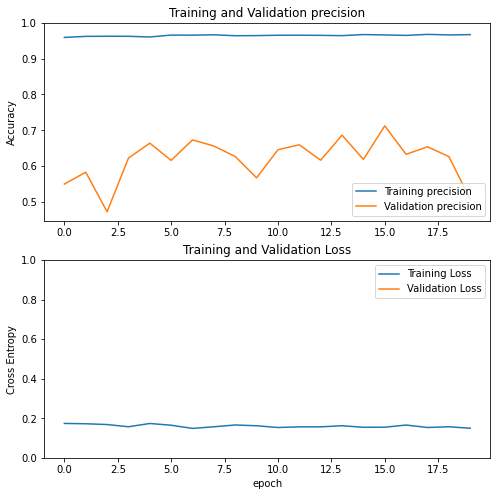

In [55]:
# acc = history.history['accuracy']
# val_acc = history.history['val_accuracy']

acc = history.history['precision']
val_acc = history.history['val_precision']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training precision')
plt.plot(val_acc, label='Validation precision')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation precision')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [34]:
# model.save("Models/ResNet50-STBv1.0_8")
new_model.save("Models/ResNet50-STBv1.0_10")

INFO:tensorflow:Assets written to: Models/ResNet50-STBv1.0_10/assets


INFO:tensorflow:Assets written to: Models/ResNet50-STBv1.0_10/assets


In [58]:
# Load the best model (u should have saved it from the checkpoints above)
# model_ = tf.keras.models.load_model("/content/drive/MyDrive/Tuner/resnet50_stb_v1_0_6.08.h5")  
model_ = tf.keras.models.load_model("Tuner/resnet50_stb_v1_0_11.16.h5")  
# /home/ai-05/Desktop/sdp/Tuner

Note that input tensors are instantiated via `tensor = tf.keras.Input(shape)`.
The tensor that caused the issue was: KerasTensor(type_spec=TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_2'), name='input_2', description="created by layer 'input_2'")


Note that input tensors are instantiated via `tensor = tf.keras.Input(shape)`.
The tensor that caused the issue was: KerasTensor(type_spec=TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_2'), name='input_2', description="created by layer 'input_2'")


In [59]:
# model_.save("/content/drive/My Drive/Models/ResNet50-STBv1.0_6")
model_.save("Models/resnet50_stb_v1_0_11")

INFO:tensorflow:Assets written to: Models/resnet50_stb_v1_0_11/assets


INFO:tensorflow:Assets written to: Models/resnet50_stb_v1_0_11/assets


## Evaluation and Predictions

In [73]:
# Evaluating on a new dataset from the internet
# paper and plastic from  https://www.kaggle.com/datasets/arthurcen/waste-images-from-sushi-restaurant
# can from https://universe.roboflow.com/dataset-t7hz7/cans-fdboa/dataset/1
test_dir = pathlib.Path("Dataset-testing (from internet)")
# test_dir = pathlib.Path("WasteImagesDataset")

batch_size = 32
image_height = 224
image_width = 224

test_ds = tf.keras.utils.image_dataset_from_directory(
  test_dir,
  seed=123,
  image_size=(image_height, image_width),
  batch_size=batch_size)


Found 699 files belonging to 3 classes.


In [ ]:
model = tf.keras.models.load_model("Models/ResNet50-STBv1.0_6")

In [72]:
model.evaluate(test_ds)
# print('Test accuracy :', accuracy)

82/82 [==============================] - 102s 1s/step - loss: 0.5662 - accuracy: 0.7990


[0.5661628842353821, 0.7990007400512695]

In [ ]:
num_trials = 15
from kerastuner import HyperParameters
tuner_hps_summary = tuner.get_best_hyperparameters(num_trials=num_trials)

In [ ]:
summary_dict = {}
for i,a in enumerate(tuner_hps_summary):
  print(f"Best trial {i}:")

  trial_dict = {}
  for hp_name, hp_value in a.values.items():
      # print(f"{hp_value}")
      trial_dict[hp_name] = hp_value
  summary_dict[i] = trial_dict

In [ ]:
import pandas as pd

# Create a pandas DataFrame from the dictionary
df = pd.DataFrame.from_dict(summary_dict, orient='index')

# Write the DataFrame to an excel file
df.to_excel('/content/drive/My Drive/Models/output-3_1.xlsx', na_rep='')

In [ ]:
print("Best hyperparameters:")

for i,trial in enumerate(tuner_hps_summary):
  print(f"Trial {i}")
  for hp_name, hp_value in trial.values.items():
      print(f"- {hp_name}: {hp_value}")

## Convert to TfLite

In [ ]:
# Convert the model.
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model.
with open('/content/drive/My Drive/Models/ResNet50-STBv1.0_6_Lite', 'wb') as f:
  f.write(tflite_model)

In [ ]:
model.summary()